# Assignement 

You can install the required packages by opening a terminal in this repository and typing: `pip install -r requirements.txt`

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, confusion_matrix, ConfusionMatrixDisplay

## Understanding the dataset

In [7]:
df = pd.read_csv(r"C:\Users\yunus\Downloads\weatherAUS.csv")
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [8]:
df.shape

(145460, 23)

In [9]:
df.dtypes

Date              object
Location          object
MinTemp          float64
MaxTemp          float64
Rainfall         float64
Evaporation      float64
Sunshine         float64
WindGustDir       object
WindGustSpeed    float64
WindDir9am        object
WindDir3pm        object
WindSpeed9am     float64
WindSpeed3pm     float64
Humidity9am      float64
Humidity3pm      float64
Pressure9am      float64
Pressure3pm      float64
Cloud9am         float64
Cloud3pm         float64
Temp9am          float64
Temp3pm          float64
RainToday         object
RainTomorrow      object
dtype: object

The objective here is to make a logictic regression model capable of understanding meteorological data and predicting the weather. 
The data we will be using represents the data for one particular day, and we will predict the weather for the next day.
Therefore, the value to predict is `RainTomorrow`.

In [10]:
df["RainTomorrow"] = df["RainTomorrow"].replace(to_replace={"Yes":1, "No":0})
df["RainToday"] = df["RainToday"].replace(to_replace={"Yes":1, "No":0})

(array([110316.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,  31877.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

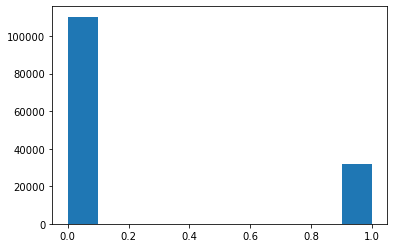

In [11]:
plt.hist(df["RainTomorrow"])

There are a lot more days not raining than days raining. It is something to keep in mind when visualizing results.

In [12]:
df.Location.unique()

array(['Albury', 'BadgerysCreek', 'Cobar', 'CoffsHarbour', 'Moree',
       'Newcastle', 'NorahHead', 'NorfolkIsland', 'Penrith', 'Richmond',
       'Sydney', 'SydneyAirport', 'WaggaWagga', 'Williamtown',
       'Wollongong', 'Canberra', 'Tuggeranong', 'MountGinini', 'Ballarat',
       'Bendigo', 'Sale', 'MelbourneAirport', 'Melbourne', 'Mildura',
       'Nhil', 'Portland', 'Watsonia', 'Dartmoor', 'Brisbane', 'Cairns',
       'GoldCoast', 'Townsville', 'Adelaide', 'MountGambier', 'Nuriootpa',
       'Woomera', 'Albany', 'Witchcliffe', 'PearceRAAF', 'PerthAirport',
       'Perth', 'SalmonGums', 'Walpole', 'Hobart', 'Launceston',
       'AliceSprings', 'Darwin', 'Katherine', 'Uluru'], dtype=object)

The column `Location` contains data about cities in Australia. It provides some geographical data and should be important. To use it, we will transform this categorical value into a numeric one.

In [13]:
df["Location"] = pd.factorize(df["Location"])[0]

We will do the same thing for columns `WindGustDir`, `WindDir9am`, and `WindDir3pm`, even though it does not seem to be useful for our prediction.

In [14]:
df["WindGustDir"] = pd.factorize(df["WindGustDir"])[0]
df["WindDir9am"] = pd.factorize(df["WindDir9am"])[0]
df["WindDir3pm"] = pd.factorize(df["WindDir3pm"])[0]

In [15]:
#Number of missing values
total = df.isnull().sum().sort_values(ascending=False)
pd.DataFrame(data={'Missing': total})

,Missing
Sunshine,69835
Evaporation,62790
Cloud3pm,59358
Cloud9am,55888
Pressure9am,15065
Pressure3pm,15028
WindGustSpeed,10263
Humidity3pm,4507
Temp3pm,3609
RainTomorrow,3267


There are a lot of missing values. We have to deal with these values to do a logistic regression.<br>
Some of them could be real missing values, like if the pressure at 9AM has not been measured. We will drop any entry that has a missing value of this type.<br>
Most of them should mean the absence of a certain element, for example if there are no clouds at 3PM. To simplify our model, we will just remove these variables.

In [16]:
df = df.drop(columns=["Sunshine","Evaporation","Cloud3pm","Cloud9am"])
df = df.dropna()

In [17]:
df.Date

0         2008-12-01
1         2008-12-02
2         2008-12-03
3         2008-12-04
4         2008-12-05
             ...    
145454    2017-06-20
145455    2017-06-21
145456    2017-06-22
145457    2017-06-23
145458    2017-06-24
Name: Date, Length: 119590, dtype: object

Date should be an important factor in predicting the weather, as it is irregular: the month is important as it indicates the season, and the year might be useful if we consider climate change. Thus, we will create additional columns from the `Date` one.

In [18]:
df["Year"] = pd.DatetimeIndex(df["Date"]).year
df["Month"] = pd.DatetimeIndex(df["Date"]).month
df = df.drop(columns="Date")
df.head()

,Location,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Year,Month
0,0,13.4,22.9,0.6,0,44.0,0,0,20.0,24.0,71.0,22.0,1007.7,1007.1,16.9,21.8,0.0,0.0,2008,12
1,0,7.4,25.1,0.0,1,44.0,1,1,4.0,22.0,44.0,25.0,1010.6,1007.8,17.2,24.3,0.0,0.0,2008,12
2,0,12.9,25.7,0.0,2,46.0,0,1,19.0,26.0,38.0,30.0,1007.6,1008.7,21.0,23.2,0.0,0.0,2008,12
3,0,9.2,28.0,0.0,3,24.0,2,2,11.0,9.0,45.0,16.0,1017.6,1012.8,18.1,26.5,0.0,0.0,2008,12
4,0,17.5,32.3,1.0,0,41.0,3,3,7.0,20.0,82.0,33.0,1010.8,1006.0,17.8,29.7,0.0,0.0,2008,12


## Feature selection

In [19]:
# correlation matrix
corrmat = df.corr()
corrmat["RainTomorrow"].sort_values(ascending=False)

RainTomorrow     1.000000
Humidity3pm      0.452645
RainToday        0.313718
Humidity9am      0.261379
Rainfall         0.237833
WindGustSpeed    0.236001
WindSpeed9am     0.095100
WindSpeed3pm     0.093832
MinTemp          0.088019
WindDir9am       0.024850
Month            0.007922
Location        -0.006308
Year            -0.013912
WindDir3pm      -0.015804
Temp9am         -0.023738
WindGustDir     -0.062147
MaxTemp         -0.160257
Temp3pm         -0.195060
Pressure3pm     -0.228156
Pressure9am     -0.246457
Name: RainTomorrow, dtype: float64

There are no variable that are strongly correlated to the target. Variables that are close to 0 have a low correlation. We will arbitrarily decide to remove variables that have a correlation below 0.1.<br>
Our previous guesses about the date and the location revealed to be wrong, meaning that knowing the meteorological values of the day is enough for our predictions.

In [20]:
df = df.drop(columns=["WindSpeed9am","WindSpeed3pm","MinTemp","WindDir9am","Month","Location","Year","WindDir3pm","Temp9am","WindGustDir"])

## Model

In [21]:
#Dataset split
y = np.array(df['RainTomorrow'])
X = np.array(df.drop('RainTomorrow', axis=1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [22]:
model = LogisticRegression(max_iter=10000)

# train
model.fit(X_train, y_train)

# predict
y_pred = model.predict(X_test)

# test
score = np.sqrt(mean_squared_error(y_test, y_pred))
    
print('MSE: {:.2f}'.format(score))

MSE: 0.39


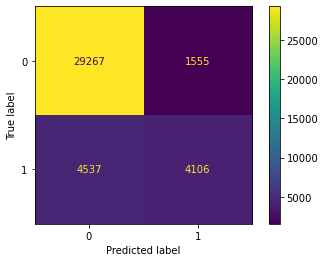

In [23]:
# confusion matrix
confmat = confusion_matrix(y_test, y_pred, labels=[0,1])
ConfusionMatrixDisplay(confmat).plot()

In [24]:
# Accuracy
acc = (confmat[0,0]+confmat[1,1])/confmat.sum()
print("Accuracy: {:2.2f} %".format(acc*100))

# Sensitivity
sen = confmat[1,1]/confmat[:,1].sum()
print("Sensitivity: {:2.2f} %".format(sen*100))

# Specificity
spe = confmat[0,0]/confmat[:,0].sum()
print("Specificity: {:2.2f} %".format(spe*100))


Accuracy: 84.56 %
Sensitivity: 72.53 %
Specificity: 86.58 %


Looking at the results, the model is doing fine with a 85% accuracy. But it also has 73% sensitivity, meaning that it has trouble predicting raining days. <br>
If we want to improve this model, we could deal with NaN values better by making "isNaN" columns, thus keeping some information, or try some more feature engineering.